This notebook showcases how a simple RSI rule can outperform Buy & Hold in risk-adjusted performance

Python 3.9.13

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go
import yfinance as yf

In [22]:
# globals
ticker = "^NDX"
rsi_days_length = 3
rsi_threshold = 30
risk_free_rate = 0.00

In [23]:
# Retrieve the maximum available historical data for daily frequency
data = yf.download(ticker, interval="1d", period="max")
data.columns = data.columns.droplevel("Ticker")
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1985-10-01 00:00:00+00:00,112.139999,112.139999,112.160004,110.565002,110.620003,153160000
1985-10-02 00:00:00+00:00,110.824997,110.824997,112.540001,110.779999,112.139999,164640000
1985-10-03 00:00:00+00:00,110.870003,110.870003,111.184998,110.120003,110.839996,147300000
1985-10-04 00:00:00+00:00,110.074997,110.074997,110.870003,109.855003,110.870003,147900000
1985-10-07 00:00:00+00:00,108.199997,108.199997,110.135002,108.175003,110.074997,128640000
...,...,...,...,...,...,...
2024-10-28 00:00:00+00:00,20351.070312,20351.070312,20470.429688,20344.820312,20455.009766,5641660000
2024-10-29 00:00:00+00:00,20550.650391,20550.650391,20600.099609,20294.580078,20369.080078,6881170000
2024-10-30 00:00:00+00:00,20387.699219,20387.699219,20559.519531,20378.750000,20510.919922,6514690000


In [24]:
# strategy logic
def create_strategy(data):
    data['RSI'] = ta.rsi(data['Adj Close'], length=rsi_days_length)  # You can adjust the length if needed
    data["exit_condition"] = data['Adj Close'] > data['High'].shift(1)
    data["entry_condition"] = (data['RSI'] < rsi_threshold)

    position_array = np.zeros(len(data))

    # Initialize in_position flag
    in_position = False

    # Loop through the DataFrame to update positions
    for i in range(1, len(data)):
        if not in_position and data['entry_condition'].iloc[i]:
            position_array[i] = 1  # Enter position
            in_position = True
        elif in_position and data['exit_condition'].iloc[i]:
            position_array[i] = 0  # Exit position
            in_position = False
        else:
            position_array[i] = position_array[i-1]  # Maintain position

    # Assign the updated position_array to the Position column
    data['Position'] = position_array

    # Calculate daily returns and strategy returns
    data['Daily Return'] = data['Adj Close'].pct_change()
    data['Strategy Return'] = data['Position'].shift(1) * data['Daily Return']

    # Calculate cumulative returns for strategy and benchmark (buy-and-hold)
    data['Strategy Cumulative'] = (1 + data['Strategy Return']).cumprod()
    data['Benchmark Cumulative'] = (1 + data['Daily Return']).cumprod()

    return data

strategy_df = create_strategy(data)
strategy_df

Price,Adj Close,Close,High,Low,Open,Volume,RSI,exit_condition,entry_condition,Position,Daily Return,Strategy Return,Strategy Cumulative,Benchmark Cumulative
Date,,,,,,,,,,,,,,
1985-10-01 00:00:00+00:00,112.139999,112.139999,112.160004,110.565002,110.620003,153160000,NaN,False,False,0.0,NaN,NaN,NaN,NaN
1985-10-02 00:00:00+00:00,110.824997,110.824997,112.540001,110.779999,112.139999,164640000,NaN,False,False,0.0,-0.011726,-0.000000,1.000000,0.988274
1985-10-03 00:00:00+00:00,110.870003,110.870003,111.184998,110.120003,110.839996,147300000,NaN,False,False,0.0,0.000406,0.000000,1.000000,0.988675
1985-10-04 00:00:00+00:00,110.074997,110.074997,110.870003,109.855003,110.870003,147900000,2.128756,False,True,1.0,-0.007171,-0.000000,1.000000,0.981585
1985-10-07 00:00:00+00:00,108.199997,108.199997,110.135002,108.175003,110.074997,128640000,0.710663,False,True,1.0,-0.017034,-0.017034,0.982966,0.964865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28 00:00:00+00:00,20351.070312,20351.070312,20470.429688,20344.820312,20455.009766,5641660000,63.502208,False,False,0.0,-0.000047,-0.000000,82.274869,181.479137
2024-10-29 00:00:00+00:00,20550.650391,20550.650391,20600.099609,20294.580078,20369.080078,6881170000,82.116684,True,False,0.0,0.009807,0.000000,82.274869,183.258877
2024-10-30 00:00:00+00:00,20387.699219,20387.699219,20559.519531,20378.750000,20510.919922,6514690000,50.545168,False,False,0.0,-0.007929,-0.000000,82.274869,181.805773


In [25]:
# Calculate key performance metrics
def calculate_performace_stats(strategy_df):

    strategy_df['Strategy Excess Return'] = strategy_df['Strategy Return'] - risk_free_rate
    strategy_tr = strategy_df['Strategy Cumulative'].iloc[-1] - 1
    strategy_ar = (strategy_df['Strategy Cumulative'].iloc[-1] ** (252 / len(strategy_df)) - 1)/100
    strategy_max_dd = (strategy_df['Strategy Cumulative'] / strategy_df['Strategy Cumulative'].cummax() - 1).min()
    excess_return_std = strategy_df['Strategy Excess Return'].std()
    if excess_return_std > 0:  # Avoid division by zero
        strategy_sr = strategy_ar / excess_return_std * np.sqrt(252)
    else:
        strategy_sr = 0  # or a default value, as applicable

    return strategy_tr, strategy_ar, strategy_max_dd, strategy_sr

strategy_df['Benchmark Excess Return'] = strategy_df['Daily Return'] - risk_free_rate
benchmark_total_return = strategy_df['Benchmark Cumulative'].iloc[-1] - 1
benchmark_annualized_return = (strategy_df['Benchmark Cumulative'].iloc[-1] ** (252 / len(strategy_df)) - 1)/100
benchmark_max_drawdown = (strategy_df['Benchmark Cumulative'] / strategy_df['Benchmark Cumulative'].cummax() - 1).min()
benchmark_sharpe_ratio = (benchmark_annualized_return) / strategy_df['Benchmark Excess Return'].std() * np.sqrt(252)
strategy_tr, strategy_ar, strategy_max_dd, strategy_sr = calculate_performace_stats(strategy_df)

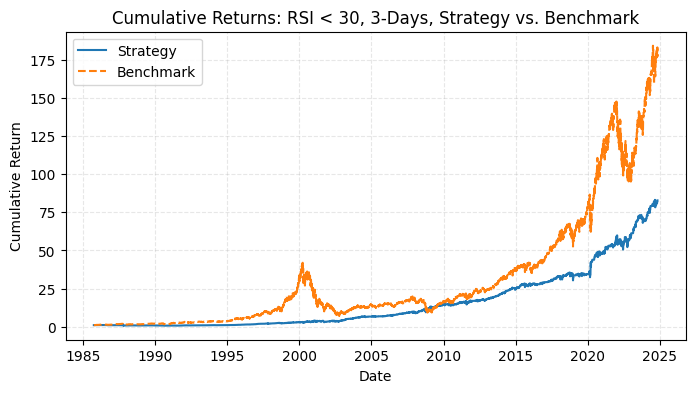

Strategy Total Return: 8186.52%
Strategy Annualized Return: 0.12%
Strategy Max Drawdown: -43.29%
Strategy Sharpe Ratio: 1.75
Benchmark Total Return: 17764.40%
Benchmark Annualized Return: 0.14%
Benchmark Max Drawdown: -82.90%
Benchmark Sharpe Ratio: 1.37


In [26]:
# Plot cumulative returns
plt.figure(figsize=(8, 4))
plt.plot(strategy_df['Strategy Cumulative'], label='Strategy')
plt.plot(strategy_df['Benchmark Cumulative'], label='Benchmark', linestyle='--')
plt.title(f"Cumulative Returns: RSI < {rsi_threshold}, {rsi_days_length}-Days, Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(linestyle="--",alpha=0.3)
plt.show()

# Print key performance metrics
print(f"Strategy Total Return: {strategy_tr:.2%}")
print(f"Strategy Annualized Return: {strategy_ar:.2%}")
print(f"Strategy Max Drawdown: {strategy_max_dd:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_sr:.2f}")
print(f"Benchmark Total Return: {benchmark_total_return:.2%}")
print(f"Benchmark Annualized Return: {benchmark_annualized_return:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown:.2%}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

# Optimization

In [27]:
rsi_days_lengths = [2, 3, 5, 10, 14, 20]
rsi_thresholds = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70]
sharpe_ratios = np.zeros((len(rsi_days_lengths), len(rsi_thresholds)))
for i, rsi_days_length in enumerate(rsi_days_lengths):
    for j, rsi_threshold in enumerate(rsi_thresholds):
        strategy_df = create_strategy(data)
        strategy_tr, strategy_ar, strategy_max_dd, strategy_sr = calculate_performace_stats(strategy_df)
        sharpe_ratios[i, j] = strategy_sr
X, Y = np.meshgrid(rsi_thresholds, rsi_days_lengths)

In [28]:
# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=sharpe_ratios, x=rsi_thresholds, y=rsi_days_lengths)])
fig.update_layout(
    title='3D Plot of Sharpe Ratios',
    scene=dict(
        xaxis_title='RSI Thresholds',
        yaxis_title='RSI Days Lengths',
        zaxis_title='Sharpe Ratio',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))  # Adjust camera view
    ),
    margin=dict(l=60, r=20, b=60, t=40),  # Adjust margins
)
fig.show()

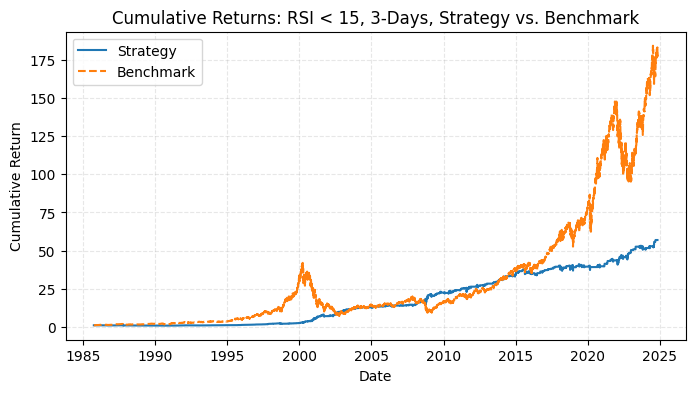

Strategy Total Return: 5593.49%
Strategy Annualized Return: 0.11%
Strategy Max Drawdown: -30.95%
Strategy Sharpe Ratio: 2.09
Benchmark Total Return: 17764.40%
Benchmark Annualized Return: 0.14%
Benchmark Max Drawdown: -82.90%
Benchmark Sharpe Ratio: 1.37


In [29]:
# plot optimum sr
max_indices = np.unravel_index(np.argmax(sharpe_ratios), sharpe_ratios.shape)  # Get the indices of the max Sharpe Ratio
rsi_days_length = rsi_days_lengths[max_indices[0]]  # Corresponding RSI Days Length
rsi_threshold = rsi_thresholds[max_indices[1]]  # Corresponding RSI Threshold
strategy_df = create_strategy(data)
strategy_tr, strategy_ar, strategy_max_dd, strategy_sr = calculate_performace_stats(strategy_df)

# Plot cumulative returns
plt.figure(figsize=(8, 4))
plt.plot(strategy_df['Strategy Cumulative'], label='Strategy')
plt.plot(strategy_df['Benchmark Cumulative'], label='Benchmark', linestyle='--')
plt.title(f"Cumulative Returns: RSI < {rsi_threshold}, {rsi_days_length}-Days, Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(linestyle="--",alpha=0.3)
plt.show()

# Print key performance metrics
print(f"Strategy Total Return: {strategy_tr:.2%}")
print(f"Strategy Annualized Return: {strategy_ar:.2%}")
print(f"Strategy Max Drawdown: {strategy_max_dd:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_sr:.2f}")
print(f"Benchmark Total Return: {benchmark_total_return:.2%}")
print(f"Benchmark Annualized Return: {benchmark_annualized_return:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown:.2%}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")